In [35]:
import numpy as np
import cv2
from typing import Iterable, Tuple
import matplotlib.pyplot as plt
from typing import List

In [36]:
def blockwise_optical_flow(
        source_image: np.ndarray,
        target_image: np.ndarray,
        window_size: Tuple[int] = (7, 7),
        d_x: int = 3,
        d_y: int = 3,
        u_ref: np.ndarray = None,
        v_ref: np.ndarray = None
) -> Iterable:
    u_ref = np.zeros_like(source_image, dtype=np.int8) if u_ref is None else u_ref
    v_ref = np.zeros_like(source_image, dtype=np.int8) if v_ref is None else v_ref

    u_indices: np.ndarray = np.zeros_like(source_image, dtype=np.int8)
    v_indices: np.ndarray = np.zeros_like(source_image, dtype=np.int8)
    
    w_y: int = window_size[0]//2
    w_x: int = window_size[1]//2
    for y in range(w_y+1, source_image.shape[0] - w_y -1):
        for x in range(w_x+1, source_image.shape[1] - w_x -1):
            roi = source_image[y-w_y: y+w_y+1, x-w_x: x+w_x+1].astype(np.float32)

            x_best = -1
            y_best = -1
            min_error = np.inf

            for y_ in range(max(w_y, y-d_y), min(y+d_y+1, target_image.shape[0] - w_y -1)):
                for x_ in range(max(w_x, x-d_x), min(x+d_x+1, target_image.shape[1] - w_x -1)):
                    roi_ = target_image[y_- w_y: y_+w_y+1, x_- w_x: x_+w_x+1].astype(np.float32)
                    error = np.sum(np.abs(roi - roi_))
                    if error < min_error:
                        min_error = error
                        x_best = x_-x
                        y_best = y_-y
            u_indices[y, x] = x_best + u_ref[y, x]
            v_indices[y, x] = y_best + v_ref[y, x]

    return u_indices, v_indices

In [37]:
def visualize_optical_flow(
        u: np.ndarray,
        v: np.ndarray,
) -> None:
        hsv = np.zeros((u.shape[0], u.shape[1], 3), dtype=np.uint8)
        mag, ang = cv2.cartToPolar(u.astype(np.float64), v.astype(np.float64))
        hsv[:,:,0] = ang*180/np.pi/2
        hsv[:,:,1] = 255
        hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        plt.imshow(rgb)
        plt.show()

In [38]:
def pyramid(
        image: np.ndarray, 
        max_scale: int = 3
        ) -> List[np.ndarray]:
    images = [image]
    for k in range(1, max_scale):
        images.append(cv2.resize(images[k-1], (0,0), fx=0.5, fy=0.5))
    return images[::-1]

In [39]:
def multi_scale_optical_flow(
        source_image: np.ndarray,
        target_image: np.ndarray,
        window_size: Tuple[int] = (7, 7),
        d_x: int = 3,
        d_y: int=3,
        n_levels: int = 3,
) -> Tuple[np.ndarray, np.ndarray]:
    source_images = pyramid(source_image, n_levels)
    target_images = pyramid(target_image, n_levels)

    u_indices: np.ndarray = np.zeros_like(source_images[0], dtype=np.int8)
    v_indices: np.ndarray = np.zeros_like(source_images[0], dtype=np.int8)

    for s_image, t_image in zip(source_images, target_images):

        u_indices, v_indices = blockwise_optical_flow(
            s_image, 
            t_image, 
            window_size=window_size,
            d_x=d_x,
            d_y=d_y,
            u_ref=u_indices, 
            v_ref=v_indices,
            )
        
        v_indices=cv2.resize(v_indices, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        u_indices=cv2.resize(u_indices, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    
    return u_indices, v_indices

In [40]:
source_image = cv2.imread('data/I.jpg', cv2.IMREAD_GRAYSCALE)
target_image = cv2.imread('data/J.jpg', cv2.IMREAD_GRAYSCALE)

cm_image_s = cv2.imread('data/cm1.png', cv2.IMREAD_GRAYSCALE)
cm_image_t = cv2.imread('data/cm2.png', cv2.IMREAD_GRAYSCALE)

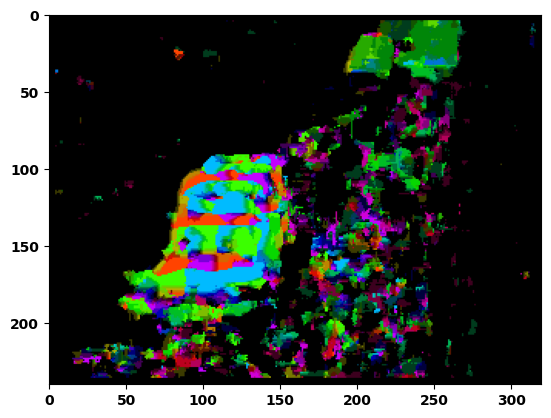

In [41]:
visualize_optical_flow(*blockwise_optical_flow(source_image, target_image))

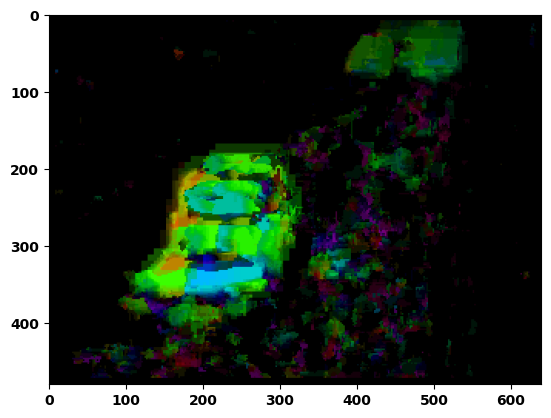

In [42]:
visualize_optical_flow(*multi_scale_optical_flow(source_image, target_image))

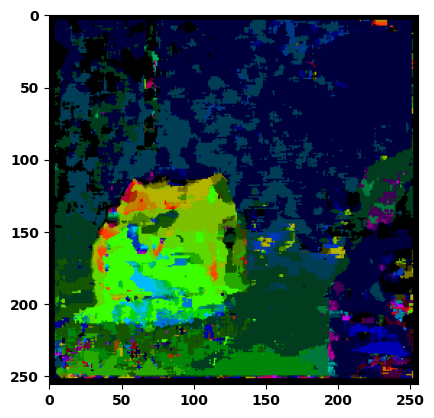

In [43]:
visualize_optical_flow(*blockwise_optical_flow(cm_image_s, cm_image_t))

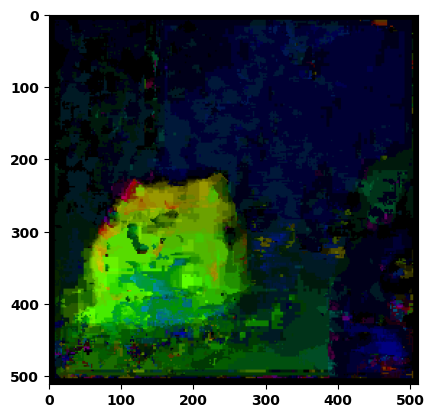

In [44]:
visualize_optical_flow(*multi_scale_optical_flow(cm_image_s, cm_image_t))